In [1]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import subprocess
import torch.nn.init as init
import time

In [2]:
# Reinforcement approach
n = 10
dimension = 1
epsilon = 0.2  # Distance to connect vertices
sigma = 0.4 # Standard deviation for random sampling
p = 0.9  # Probability of not generating a new point at random
seq_length = dimension*n # each vertex has "dimension" coordinates 
input_size = seq_length
hidden_size = 32
output_size = dimension  # Outputs a new point

In [3]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Net,self).__init__()
    self.nn_stack = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.Sigmoid(),
        nn.Linear(128, 64),
        nn.Sigmoid(),
        nn.Linear(64, 4),
        nn.Sigmoid(),
        nn.Linear(4, output_size),
        nn.Sigmoid()  
    )
    self.apply(self.init_weights)  # Apply custom initialization

  def forward(self, x):
    y = self.nn_stack(x)
    return(y)

  def optimize(self, input, output):
    self.train()
    for input_seq, target in zip(input, output):
      optimizer.zero_grad()
      pred = self(input_seq)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()
    return loss.item()

  def init_weights(self, m):
    if isinstance(m, nn.Linear):
      init.xavier_uniform_(m.weight)  # Xavier initialization
      init.zeros_(m.bias)  # Initialize biases to zero

In [4]:
model = Net(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()   # Using MSE loss

In [5]:
def generate_sequence(length, noise=True):
  seq = torch.zeros(length)  # Actual sequence
  #ind = torch.zeros(length)  # Indicator of location
  for i in range(n):
    #ind[i] = 1
    with torch.no_grad():
      r = np.random.rand()
      if r < p:  # Pick new point accoding to neural net
        new_pt_mean = model(seq)
        noise = np.random.randn(dimension)
        if noise: # A noise to selected point
          new_pt = torch.clamp(new_pt_mean+sigma*noise, min=0, max=1)
        else:
          new_pt = new_pt_mean
      else: # Add random point with probability 1-p
        new_pt = torch.tensor(np.random.rand(dimension))
      seq[dimension*i:dimension*(i+1)] = new_pt  # Add new point to the sequence
  return(seq)

In [6]:
def build_graph(seq, epsilon):
    adj_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1,n):
            dist = np.linalg.norm(seq[i*dimension:(i+1)*dimension]-seq[j*dimension:(j+1)*dimension])
            if dist < epsilon:
                adj_mat[i,j] = 1
                adj_mat[j,i] = 1
    return(adj_mat)

In [7]:
def generate_seq_matrix(N, length):
  mat = torch.zeros(N,length)
  # First generate a sequence with no noise
  new_seq = generate_sequence(length, noise=False)
  mat[0,:] = new_seq
  # Add the other sequences
  for i in range(1,N):
    new_seq = generate_sequence(length)
    mat[i,:] = new_seq
  return(mat)

In [8]:
def reward_fcn(seq):
    adj = build_graph(seq, epsilon)
    G = nx.from_numpy_array(adj)
    # Calculate reward for a given graph and we want to penalize disconnected graphs
    # if not nx.is_connected(G):
    #     return -1000
    # n = n
    # matching_number = len(nx.algorithms.matching.max_weight_matching(G, maxcardinality=True))
    # eigenvalues = np.linalg.eigvals(adj)
    # largest_eigenvalue = np.max(np.abs(eigenvalues))
    # reward = math.sqrt(n - 1) + 1 - matching_number - largest_eigenvalue

    if not (len(list(nx.simple_cycles(G))) == 0):
        return -1000
    seq_int = seq.to(torch.int)
    num_edges = G.number_of_edges()
    max_degree = max([val for (node, val) in G.degree()])
    reward = ((3.5 * num_edges) / n) - max_degree
    return(reward)

In [9]:
def elite_sequences(seq_matrix, top_perc):
    N = seq_matrix.shape[0]
    reward_vec = torch.zeros(N)
    for i in range(N):
        reward_vec[i] = reward_fcn(seq_matrix[i,:])
    num_samples = int(np.round(top_perc*N))
    elite_indices = torch.argsort(reward_vec, descending=True)[0:num_samples]
    elite_reward = reward_vec[elite_indices]
    elite_matrix = seq_matrix[elite_indices,:]
    return([elite_matrix, elite_reward])

In [10]:
# Create input/output pairs for a given matrix of sequences
def create_pairs(seq_matrix):
  N, p = seq_matrix.shape
  input = torch.zeros(N*(n-1), p)
  output = torch.zeros(N*(n-1), dimension)
  counter = 0
  for i in range(N):
    # Processing sequence i
    for j in range(n-1):
      # Partial sequence
      seq = torch.zeros(p)
      seq[0:(j+1)*dimension] = seq_matrix[i,0:(j+1)*dimension]
      input[counter,:] = seq
      output[counter,:] =  seq_matrix[i,(j+1)*dimension:(j+2)*dimension]
      counter += 1
  return([input, output])

In [11]:
# Start training
batch_size = 500  # Number of generated sequences per training
num_train = 10000 # Number of iterations

current_elites = generate_seq_matrix(batch_size, seq_length)
program_start_time = time.perf_counter()

print("Max elite   Mean elite")
for i in range(num_train):
    # Generate new sample
    seq_mat = generate_seq_matrix(batch_size, seq_length)
    # Add new samples to elite matrix
    current_elites = torch.concat([current_elites, seq_mat])
    # Pick top 5% samples 
    current_elites, elite_rewards = elite_sequences(current_elites, 0.05)
    # Update model parameters
    input, output = create_pairs(current_elites)
    loss = model.optimize(input, output)
    max_elite = elite_rewards.max()
    mean_elite = elite_rewards.mean()
    print(max_elite, mean_elite)
    if max_elite > 0:
        print("Counterexample found!")
        #send_email()
        break

program_runtime = time.perf_counter() - program_start_time
print("Program Runtime:", program_runtime, "seconds\n")

Max elite   Mean elite
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(-1000.) tensor(-1000.)
tensor(0.7500) tensor(-961.5096)
Counterexample found!
Program Runtime: 28.7915131 seconds



In [12]:
elite_rewards

tensor([ 7.5000e-01, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03])

In [13]:
current_elites[0,:]

tensor([0.7430, 0.0000, 0.2002, 0.0000, 0.9948, 0.6962, 0.4576, 0.2082, 0.4533,
        0.9767])

In [14]:
reward_fcn(current_elites[0,:])

0.75

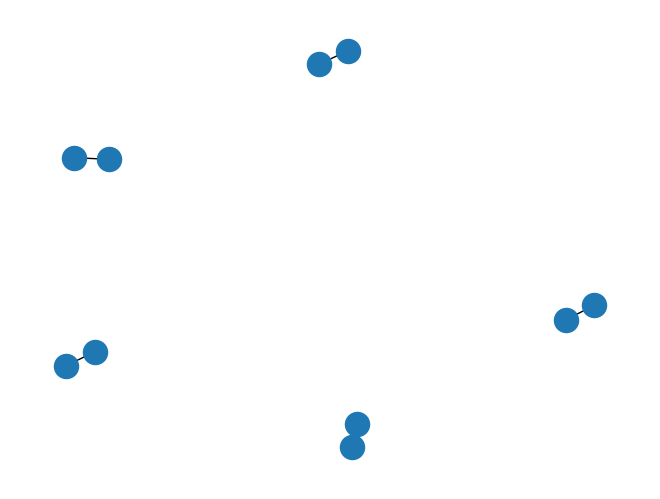

In [17]:
adj_matrix = build_graph(current_elites[0,:],epsilon)
counterexample_graph = nx.Graph(adj_matrix)
nx.draw(counterexample_graph)
plt.savefig("counterexample1.png", format="PNG")
plt.show()

In [18]:
counterexample_graph.number_of_edges()

5